<a href="https://colab.research.google.com/github/ahzaidy/Programs/blob/main/CPSC_5410_HW1_P4_BO_LCB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

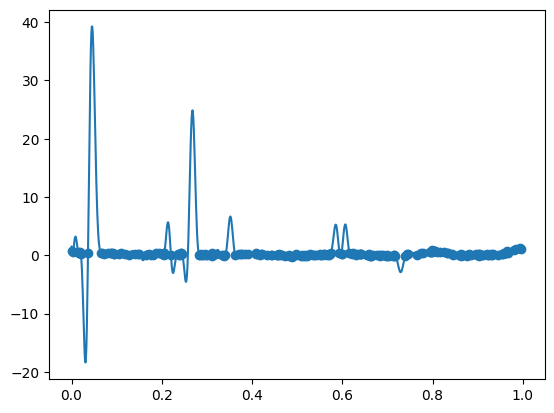

>x=0.030, f()=-18.296, actual=0.432
>x=0.055, f()=-13.076, actual=0.262
>x=0.042, f()=-6.201, actual=0.334
>x=0.255, f()=-4.256, actual=0.033
>x=0.224, f()=-2.950, actual=0.314
>x=0.252, f()=-1.406, actual=0.231
>x=0.729, f()=-2.912, actual=0.011
>x=0.757, f()=-2.063, actual=0.197
>x=0.178, f()=-0.791, actual=0.152
>x=0.134, f()=-0.790, actual=0.178
>x=0.492, f()=-0.574, actual=-0.015
>x=0.752, f()=-0.391, actual=0.023
>x=0.735, f()=-0.485, actual=-0.157
>x=0.259, f()=-0.421, actual=0.218
>x=0.722, f()=-0.473, actual=0.077
>x=0.850, f()=-0.257, actual=0.121
>x=0.485, f()=-0.307, actual=-0.029
>x=0.596, f()=-0.268, actual=0.260
>x=0.948, f()=-0.228, actual=0.188
>x=0.734, f()=-0.174, actual=0.026
>x=0.873, f()=-0.173, actual=0.108
>x=0.664, f()=-0.155, actual=-0.040
>x=0.364, f()=-0.167, actual=0.171
>x=0.395, f()=-0.309, actual=0.098
>x=0.315, f()=-0.229, actual=0.098
>x=0.489, f()=-0.167, actual=-0.093
>x=0.490, f()=-0.132, actual=-0.060
>x=0.328, f()=-0.655, actual=-0.181
>x=0.488, f

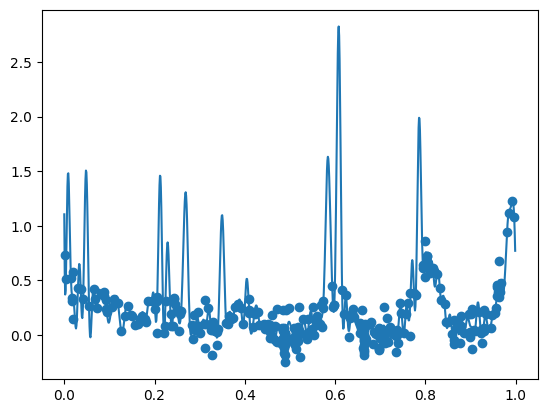

Best Result: x=0.488, y=-0.250


In [2]:
from math import sin, cos, pi
from numpy import arange, vstack, argmin, asarray
from numpy.random import normal, random
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from warnings import catch_warnings, simplefilter
from matplotlib import pyplot
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

# Objective function
def objective(x, noise=0.1):
    noise = normal(loc=0, scale=noise)
    return ((x-0.6) ** 2 + x ** 2 * cos(5 * pi * x) ** 6.0) + noise

# Surrogate function
def surrogate(model, X):
    with catch_warnings():
        simplefilter("ignore")
        return model.predict(X, return_std=True)

# LCB (Lower Confidence Bound) acquisition function
def acquisition(X, Xsamples, model, kappa=1.96):
   # calculate the best surrogate score found so far
    yhat, _ = surrogate(model, X)
    best = max(yhat)
    mu, std = surrogate(model, Xsamples)
    scores = mu - kappa * std  # Lower confidence bound
    return scores

# Optimize the acquisition function
def opt_acquisition(X, y, model):
#    Xsamples = random(100).reshape(-1, 1)
    Xsamples = random(100)
    Xsamples = Xsamples.reshape(len(Xsamples), 1)
    scores = acquisition(X, Xsamples, model)
    ix = argmin(scores)  # Select the point with the lowest acquisition score
    return Xsamples[ix, 0]

# Plot function
def plot(X, y, model, img_name='plot'):
    pyplot.scatter(X, y)
    # Xsamples = asarray(arange(0, 1, 0.001)).reshape(-1, 1)
    Xsamples = asarray(arange(0, 1, 0.001))
    Xsamples = Xsamples.reshape(len(Xsamples), 1)
    ysamples, _ = surrogate(model, Xsamples)
    pyplot.plot(Xsamples, ysamples)
    pyplot.show()
    pyplot.close()

# Sample the domain sparsely with noise
X = random(200)
y = asarray([objective(x) for x in X])
X = X.reshape(len(X), 1)
y = y.reshape(len(y), 1)

# Define the model
kernel = RBF(length_scale=0.1, length_scale_bounds=(1e-2, 10.0))
model = GaussianProcessRegressor(kernel=kernel, alpha=1e-6, n_restarts_optimizer=2)

# Fit the model using X, y
model.fit(X, y)

# Plot before optimization
plot(X, y, model, img_name='gp_initial_model')

# Perform the optimization process
for i in range(100):
    # Select the next point to sample
    x = opt_acquisition(X, y, model)
    # Sample the point
    actual = objective(x)
    # Summarize the finding
    est, _ = surrogate(model, [[x]])
    print('>x=%.3f, f()=%.3f, actual=%.3f' % (x, est[0], actual))
    # Add the data to the dataset
    X = vstack((X, [[x]]))
    y = vstack((y, [[actual]]))
    # Update the model
    model.fit(X, y)

# Plot final result
plot(X, y, model, img_name='gp_result_model')

# Best result
ix = argmin(y)
print('Best Result: x=%.3f, y=%.3f' % (X[ix].item(), y[ix].item()))